# Analyze results of FP32 vs FP16 Quantization

In [1]:
import os
import pandas as pd
import json
from notebook_utils import load_mpl_style

load_mpl_style()
fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)

## Load metrics from scene JSON files

In [2]:
def load_results(results_dir: str) -> dict:
    results = {}
    for scene in sorted(os.listdir(results_dir)):
        metrics_path = os.path.join(results_dir, scene, "render_metrics.json")
        with open(metrics_path, "r") as f:
            results[scene] = json.load(f)
    print(f"Loaded {len(results)} scene results from {results_dir}")
    return results

results_fp32 = load_results("../results")
results_fp16 = load_results("../results_fp16")

Loaded 8 scene results from ../results
Loaded 8 scene results from ../results_fp16


In [3]:
df_fp32 = pd.DataFrame.from_dict(results_fp32, orient="index")
df_fp16 = pd.DataFrame.from_dict(results_fp16, orient="index")
assert df_fp16['use_fp16'].all()

In [4]:
# Merge results into single dataframe
df_compare = df_fp32.copy()
df_compare = df_compare.drop(
    columns=["use_fp16", "scene", "checkpoint", "num_downscales", 
             "psnrs", "lpips", "og_size", "quantized_size"]
)
df_compare = df_compare.add_prefix('fp32_')

df_fp16_relevant = df_fp16[["render_time", "psnr_avg", "power_draw_avg", "energy", "lpips_avg"]]
df_fp16_relevant = df_fp16_relevant.add_prefix('fp16_')

df_compare = df_compare.join(df_fp16_relevant)
df_compare

,fp32_render_time,fp32_psnr_avg,fp32_power_draw_avg,fp32_energy,fp32_lpips_avg,fp16_render_time,fp16_psnr_avg,fp16_power_draw_avg,fp16_energy,fp16_lpips_avg
chair,116.754415,35.106121,322.745,37681.903532,0.025573,43.742688,33.905234,269.685,11796.746798,0.031763
drums,121.699046,26.245696,322.890,39295.404817,0.064089,44.754623,25.934531,271.530,12152.222751,0.070676
ficus,60.629561,32.927028,303.205,18383.186188,0.018331,26.214829,32.065000,251.020,6580.446429,0.023544
hotdog,243.523932,36.930002,338.745,82492.514375,0.032591,81.122944,36.241094,292.390,23719.537453,0.036598
lego,154.571539,33.719887,323.375,49984.571543,0.027929,54.092843,32.742109,293.780,15891.395431,0.033588
materials,148.086400,30.339982,321.120,47553.504713,0.043826,51.447307,29.861328,285.450,14685.633703,0.052197
mic,119.692415,9.083419,321.935,38533.177559,0.334989,43.010924,9.084258,273.070,11744.992939,0.336483
ship,354.269128,29.849499,336.880,119346.183849,0.150662,114.588152,29.433750,315.865,36194.386755,0.156542


### Compute the speedup ratio and energy ratio between FP32 and FP16

`ratio = fp32_metric / fp16_metric`

In [5]:
df_compare["render_speedup"] = df_compare["fp32_render_time"] / df_compare["fp16_render_time"]
df_compare["render_speedup"]

chair        2.669118
drums        2.719251
ficus        2.312796
hotdog       3.001912
lego         2.857523
materials    2.878409
mic          2.782838
ship         3.091673
Name: render_speedup, dtype: float64

In [6]:
df_compare["energy_improvement"] = df_compare["fp32_energy"] / df_compare["fp16_energy"]
df_compare["energy_improvement"]

chair        3.194262
drums        3.233598
ficus        2.793608
hotdog       3.477830
lego         3.145386
materials    3.238097
mic          3.280817
ship         3.297367
Name: energy_improvement, dtype: float64

### Plot grouped barchart

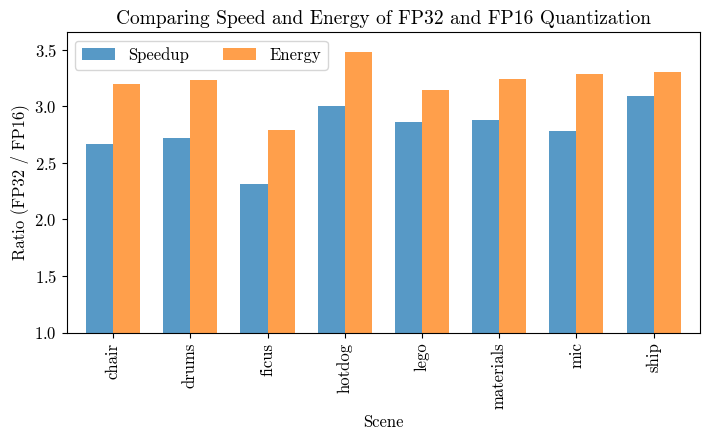

In [7]:
ax = df_compare.plot.bar(
    y=["render_speedup", "energy_improvement"], 
    width=0.7, figsize=(7.2, 4.5), align="center", alpha=0.75
)
ax.set_ylim(bottom=1.0)
ax.legend(['Speedup', 'Energy'], loc="upper left", ncol=2)

ax.set_title(f"Comparing Speed and Energy of FP32 and FP16 Quantization")
ax.set_xlabel("Scene")
ax.set_ylabel("Ratio (FP32 / FP16)")
ax.figure.tight_layout()
ax.figure.savefig(f"{fig_dir}/quantization_results.pdf")